In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Project/diffq_nr/noise-reducer-ml/denoiser-inverse


In [6]:
# %cd /content/drive/MyDrive/Colab Notebooks/Project/diffq_enhancer
!python setup.py build_ext --inplace

Compiling bitpack.pyx because it changed.
[1/1] Cythonizing bitpack.pyx
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/MyDrive/Colab Notebooks/Project/diffq_nr/noise-reducer-ml/denoiser-inverse/bitpack.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'bitpack' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.7m -c bitpack.c -o build/temp.linux-x86_64-3.7/bitpack.o
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 -Wl,-Bsymbolic-functions -g -fwrapv -O2 -g -fstack-protector-strong -Wforma

In [ ]:
!python3 enhance2.py

2022-06-21 07:57:43.503773: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
50.0
100.0


In [2]:
!pip3 install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 5.0 MB/s 


In [7]:
%cd /content/drive/MyDrive/Colab Notebooks/Project/diffq_nr/noise-reducer-ml/denoiser-inverse/denoiser
from demucs import Demucs
import sys
sys.path.append('..')
from Diffq import DiffQuantiazer
import pickle5 as pickle
import tensorflow as tf
import numpy as np

/content/drive/MyDrive/Colab Notebooks/Project/diffq_nr/noise-reducer-ml/denoiser-inverse/denoiser


In [8]:
def pred(model=None, noisy_path = "", model_path = ""):
		self_sample_rate = 16_000
		total_seconds_of_audio = 10
		total_number_of_sample = self_sample_rate * total_seconds_of_audio
		raw_audio_noisy = tf.io.read_file(noisy_path)
		noisy, sample_rate = tf.audio.decode_wav( raw_audio_noisy, desired_channels=1)
		number_of_total_sample = noisy.shape[0]
		number_of_chunks = (number_of_total_sample + total_number_of_sample - 1) // total_number_of_sample
		if isinstance(model, type(None)):
			model = Demucs(input_shape=(total_number_of_sample, 1))
			# print(model.summary())
			# with open('/content/drive/MyDrive/states_dns64.pickle', 'rb') as handle:
			# 	state = pickle.load(handle)
		
			# encoder = []
			# lstm = []
			# for x in state.keys():
			# 	# print(x)
			# 	if "encoder" in x:
			# 		encoder.append(state[x])
			# 	elif "decoder" in x:
			# 		encoder.append(state[x])
			# 	else:
			# 		lstm.append(state[x])
			# lstm[2] += lstm[3]
			# lstm[6] += lstm[7]

			# nlstm = []
			# for i in range(len(lstm)):
			# 	if i == 3 or i == 7:
			# 		continue
			# 	nlstm.append(lstm[i])

			# # for x in encoder:
			# #   print(x.shape)
			# print(len(encoder))
			# # print((lstm))
			# print(len(nlstm))
			# i = 0
			# j = 0
			# for layer in model.layers:
			# 	# if "encode" in layer.name:
			# 	#   for l in layer.layers:
			# 	#     print(l.name, " ", l.get_weights()[0].shape)
			# 	for par in layer.trainable_weights:
			# 		if "_diffq" not in par.name:
			# 			print(par.name, " ", par.shape)
					# 	if "con" in par.name:
					# 		par.assign(tf.constant(encoder[i]))
					# 		i += 1
					# 	else:
					# 		par.assign(tf.constant(nlstm[j]))
					# 		j += 1
					# else:
					# 	par.assign(tf.constant(np.full(par.shape, 2.4849067, dtype=np.float32)))
			# model.save_weights("/content/drive/MyDrive/weight_ini_model.h5")

			model.load_weights(model_path)
			global quantizer
			quantizer = DiffQuantiazer(model)
			state = quantizer.get_quantized_state()
			with open(f'/content/drive/MyDrive/final_state.pickle', 'wb') as handle:
				pickle.dump(state, handle, protocol=pickle.HIGHEST_PROTOCOL)
			# with open(model_path, 'rb') as handle:
			# 	state = pickle.load(handle)
			# quantizer.restore_quantized_state(state)
	 		
			# model = tf.keras.models.load_model(model_path, compile=False)
		number_of_total_sample_upperbound = number_of_chunks * total_number_of_sample
		padded_noisy = tf.pad(noisy, tf.constant([[0, number_of_total_sample_upperbound - number_of_total_sample], [0, 0]]), "CONSTANT")
		padded_noisy = tf.reshape(padded_noisy, [number_of_total_sample_upperbound // total_number_of_sample, total_number_of_sample, 1])
		# self.total_batch = number_of_total_sample_upperbound // total_number_of_sample
		# print(self.total_batch)
		# self.total_batch = (self.total_batch + self.batch_size - 1) // self.batch_size 
		# lamda_call = tf.keras.callbacks.LambdaCallback(on_predict_batch_end=self.upd)
		estimate = model.predict(padded_noisy, batch_size=1)
		estimate = tf.reshape(estimate, [number_of_total_sample_upperbound, 1])
		estimate = estimate[:number_of_total_sample,:]
		return noisy, estimate
		# match = self.noisy_path[self.noisy_path.find("fileid_") + 7:]
		# wavfile.write(self.enhanced_path + f"enhanced_{match}", 48000, tf.reshape(estimate,[-1]).numpy())
		# tf.io.write_file(self.enhanced_path, tf.audio.encode_wav(estimate, 48000))#))
		# tf.io.write_file(self.enhanced_path + f"enhanced_{match}", tf.audio.encode_wav(estimate, 48000))#))
		# tf.io.write_file(self.enhanced_path, tf.reshape(estimate,[-1]))

In [9]:
noisy, estimate = pred(noisy_path = "/content/drive/MyDrive/test.wav", model_path = "/content/drive/MyDrive/checkpoint_epoch-053_loss-0.002503.h5")

Instructions for updating:
Use tf.identity instead.


In [ ]:
from IPython.display import Audio
# print(estimate)
noisy = tf.reshape(noisy, [-1])
Audio(noisy.numpy(), rate=16000)

In [ ]:
from IPython.display import Audio
print(estimate)
estimate = tf.reshape(estimate, [-1])
Audio(estimate.numpy(), rate=16000)

tf.Tensor(
[[-1.6524189e-03]
 [-3.9524147e-03]
 [ 1.9836405e-03]
 ...
 [ 7.4761403e-05]
 [ 7.6245575e-05]
 [ 6.3109641e-05]], shape=(103896, 1), dtype=float32)


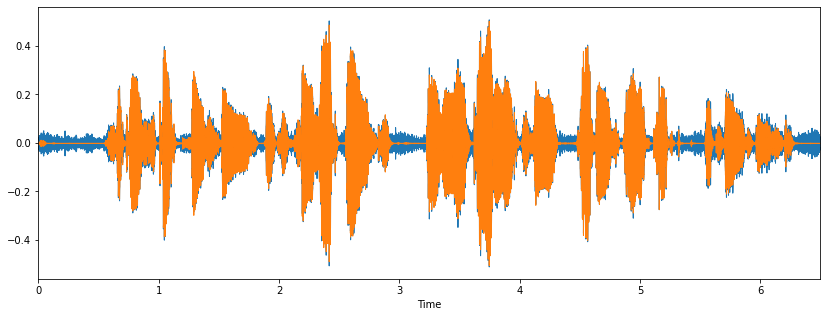

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(noisy.numpy(), sr=16000)
librosa.display.waveplot(estimate.numpy(), sr=16000)
import scipy.io.wavfile as wavfile

In [ ]:
raw_audio_noisy = tf.io.read_file("/content/sample_data/clean_fileid_2883.wav")
clean, sample_rate = tf.audio.decode_wav( raw_audio_noisy, desired_channels=1)
clean = tf.reshape(clean, [-1])
print(tf.keras.metrics.mean_absolute_error(clean, estimate))

tf.Tensor(0.007180461, shape=(), dtype=float32)


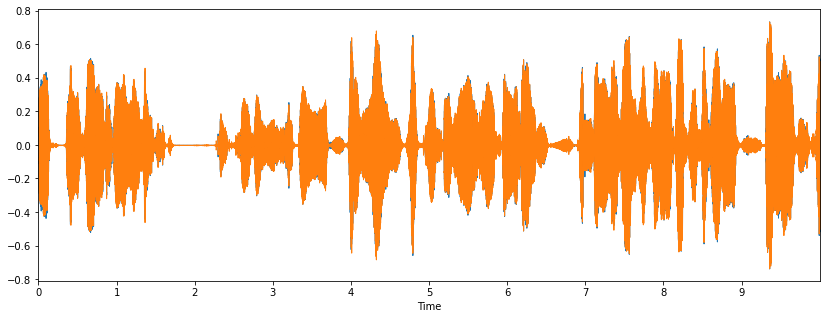

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(estimate.numpy(), sr=16000)
librosa.display.waveplot(clean.numpy(), sr=16000)
import scipy.io.wavfile as wavfile

In [ ]:
def cal_logit(x):
        """ Computes the logit function, i.e. the logistic sigmoid inverse. """
        return -tf.math.log(1. / x - 1.)

In [ ]:
t = (14.0 - 2.0) / (15.0 - 2.0)
logit = cal_logit(t)
print(logit)

tf.Tensor(2.4849067, shape=(), dtype=float32)


In [ ]:
def _get_bits(logit):
    t = tf.math.sigmoid(logit)
    return 15.0 * t + (1 - t) * 2.0

In [ ]:
print(_get_bits(2.4849067))

tf.Tensor(14.0, shape=(), dtype=float32)
